# Retrieve a CMEMS datasets - Expanded Search

This notebook used to find the practical salinity and potential temperature for Global Ocean Physics Reanalysis (https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/description) and Atlantic-Iberian Biscay Irish- Ocean Physics Reanalysis (https://data.marine.copernicus.eu/product/IBI_MULTIYEAR_PHY_005_002/description).

Now you want to move to the DTO facilities, and you are wondering how to find that dataset there. 


### 0. setup environment

#### Requirements

In [1]:
packages = ['pystac_client',
            'copernicusmarine',
            'xarray',
            'requests',
            'aiohttp',
            'copernicusmarine',
            'cartopy',
           'geopandas']

#### Install packages

In [2]:
for package in packages:
    !pip install {package} > /dev/null 2>&1

#### Load packages

In [3]:
for package in packages:
    exec(f'import {package}')

/opt/python/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import geopandas
import cartopy.crs as ccrs
import json
import ast
from copernicusmarine.core_functions import custom_open_zarr
from shapely.geometry import Point, box, Polygon, shape
import geopandas as gpd
from shapely import wkt

<br>

### 1. Open the STAC catalog
Using pystac client you can connect to the STAC.

In [5]:
url = 'https://catalog.dive.edito.eu'
client = pystac_client.Client.open(url)
print(client)

<Client id=root>


<br>

### 2. Load collections
One property of the STAC is collections, its a good way to explore the available datasets. 

In [6]:
collections = list(client.get_collections())

Lets see how many collections there are:

In [7]:
print(f"number of collections: {len(collections)}")

number of collections: 442


<br>

### 3. Query collections
We will loop over the collections and filter a variable defined in CMEMS such as: 

(1) sea water potential temperature at sea floor in the Global Reanalysis;

(2) and ocean mixed layer thickness defined by sigma theta for the Atlantic IBI Reanalysis.

Notice that we need to add underscores as spaces are not accepted.
#### 3.1 Filter on variable

In [8]:
##Global Reanalysis

#variable1 = "climate_forecast-sea_water_potential_temperature_at_sea_floor"

## Atlantic - IBI Reanalysis

variable1 = "ocean_mixed_layer_thickness_defined_by_sigma_theta"

Though these variables are not potential temperature or practical salinity, they are unique to each dataset so it is easier to find the zarr files where we can access the variables that we want to access from CMEMS. 

In [9]:
for collection in collections:
    if variable1 in collection.id:
        print(collection.id)

climate_forecast-ocean_mixed_layer_thickness_defined_by_sigma_theta


#### 3.2 Retrieve products
Get all the products from these collections.

In [10]:
products = []
for collection in collections:
    if variable1 in collection.id:
        for i, item in enumerate(collection.get_items()):
            products.append(item)

Lets see how many products this is.

In [11]:
print(f"number of products: {len(products)}")

number of products: 148


#### 3.3 Filter the products 
On the CMEMS webpage, the product ID are defined as "GLOBAL_MULTIYEAR_PHY_001_030" and "IBI_MULTIYEAR_PHY_005_002".

In [12]:
#product_id = "GLOBAL_MULTIYEAR_PHY_001_030" #GLO

product_id = "IBI_MULTIYEAR_PHY_005_002" #IBI

In [13]:
for collection in collections:
    if variable1 in collection.id:
        for i, item in enumerate(collection.get_items()):
            for asset_key, asset in item.assets.items():
                if product_id in asset.href:
                    print(i, asset.href)

4 https://s3.waw3-1.cloudferro.com/mdl-arco-geo-032/arco/IBI_MULTIYEAR_PHY_005_002/cmems_mod_ibi_phy_myint_0.083deg_P1M-m_202411/geoChunked.zarr
4 https://wmts.marine.copernicus.eu/teroWmts/IBI_MULTIYEAR_PHY_005_002/cmems_mod_ibi_phy_myint_0.083deg_P1M-m_202411?layer=IBI_MULTIYEAR_PHY_005_002/cmems_mod_ibi_phy_myint_0.083deg_P1M-m_202411/mlotst
4 https://datalab.dive.edito.eu/data-explorer?source=https://s3.waw3-1.cloudferro.com/mdl-arco-geo-032/arco/IBI_MULTIYEAR_PHY_005_002/cmems_mod_ibi_phy_myint_0.083deg_P1M-m_202411/geoChunked.zarr
5 https://s3.waw3-1.cloudferro.com/mdl-arco-time-032/arco/IBI_MULTIYEAR_PHY_005_002/cmems_mod_ibi_phy_myint_0.083deg_P1M-m_202411/timeChunked.zarr
5 https://wmts.marine.copernicus.eu/teroWmts/IBI_MULTIYEAR_PHY_005_002/cmems_mod_ibi_phy_myint_0.083deg_P1M-m_202411?layer=IBI_MULTIYEAR_PHY_005_002/cmems_mod_ibi_phy_myint_0.083deg_P1M-m_202411/mlotst
5 https://datalab.dive.edito.eu/data-explorer?source=https://s3.waw3-1.cloudferro.com/mdl-arco-time-032/arco

<br>

### 4. Open ZARR
You can then select one of the zarr files and inspect how it looks. 

In this example, we will continue with the geochunked zarr files for the Global and Atlantic Reanalyses and Interim products:

In [14]:

#GLO 
GLO_rean_zarr = "https://s3.waw3-1.cloudferro.com/mdl-arco-geo-025/arco/GLOBAL_MULTIYEAR_PHY_001_030/cmems_mod_glo_phy_my_0.083deg_P1M-m_202311/geoChunked.zarr"

GLO_int_zarr = "https://s3.waw3-1.cloudferro.com/mdl-arco-geo-026/arco/GLOBAL_MULTIYEAR_PHY_001_030/cmems_mod_glo_phy_myint_0.083deg_P1M-m_202311/geoChunked.zarr"

#IBI 
IBI_rean_zarr = "https://s3.waw3-1.cloudferro.com/mdl-arco-geo-032/arco/IBI_MULTIYEAR_PHY_005_002/cmems_mod_ibi_phy_my_0.083deg-3D_P1M-m_202012/geoChunked.zarr"

IBI_int_zarr = "https://s3.waw3-1.cloudferro.com/mdl-arco-geo-032/arco/IBI_MULTIYEAR_PHY_005_002/cmems_mod_ibi_phy_myint_0.083deg_P1M-m_202411/geoChunked.zarr"


In [15]:
from copernicusmarine.core_functions import custom_open_zarr

We are able to create xarray datasets from the custon_open_zarr function.

In [16]:
GLO_rean_ds = custom_open_zarr.open_zarr(GLO_rean_zarr)
GLO_int_ds = custom_open_zarr.open_zarr(GLO_int_zarr)

#print(GLO_int_ds)

In [17]:
IBI_rean_ds = custom_open_zarr.open_zarr(IBI_rean_zarr)
IBI_int_ds = custom_open_zarr.open_zarr(IBI_int_zarr)

#print(IBI_int_ds)

<br>

### 5. Slice data and plot
Slice the dataset based on extend in space and time. 

In this example, we are looking at data at 1000m for the MOW reservior (as shown here: https://data.marine.copernicus.eu/product/IBI_OMI_WMHE_mow/description).

In [18]:
lat_min, lat_max = (37, 41.4) 
lon_min, lon_max = (-14, -8.6)
depth_min, depth_max = (-1050, -950) #IBI
depth_min1, depth_max1 = (-1000, -900) #GLO

time_index = 0

Execute the slicing.

In [19]:
#Temp
GLO_temp_rean_subset0 = GLO_rean_ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max), elevation=slice(depth_min1, depth_max1))['thetao']
IBI_temp_rean_subset0 = IBI_rean_ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max), elevation=slice(depth_min, depth_max))['thetao']

GLO_temp_int_subset0 = GLO_int_ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max), elevation=slice(depth_min1, depth_max1))['thetao']
IBI_temp_int_subset0 = IBI_int_ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max), elevation=slice(depth_min, depth_max))['thetao']

#Sal

GLO_sal_rean_subset0 = GLO_rean_ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max), elevation=slice(depth_min1, depth_max1))['so']
IBI_sal_rean_subset0 = IBI_rean_ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max), elevation=slice(depth_min, depth_max))['so']

GLO_sal_int_subset0 = GLO_int_ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max), elevation=slice(depth_min1, depth_max1))['so']
IBI_sal_int_subset0 = IBI_int_ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max), elevation=slice(depth_min, depth_max))['so']


Interpolate the depths to 1000m.

In [20]:
GLO_temp_rean_subset = GLO_temp_rean_subset0.interp(elevation =1000, method = 'nearest', kwargs={"fill_value": "extrapolate"})
IBI_temp_rean_subset = IBI_temp_rean_subset0.interp(elevation =1000, method = 'nearest', kwargs={"fill_value": "extrapolate"})

GLO_temp_int_subset = GLO_temp_int_subset0.interp(elevation =1000, method = 'nearest', kwargs={"fill_value": "extrapolate"})
IBI_temp_int_subset = IBI_temp_int_subset0.interp(elevation =1000, method = 'nearest', kwargs={"fill_value": "extrapolate"})

GLO_sal_rean_subset = GLO_sal_rean_subset0.interp(elevation =1000, method = 'nearest', kwargs={"fill_value": "extrapolate"})
IBI_sal_rean_subset = IBI_sal_rean_subset0.interp(elevation =1000, method = 'nearest', kwargs={"fill_value": "extrapolate"})

GLO_sal_int_subset = GLO_sal_int_subset0.interp(elevation =1000, method = 'nearest', kwargs={"fill_value": "extrapolate"})
IBI_sal_int_subset = IBI_sal_int_subset0.interp(elevation =1000, method = 'nearest', kwargs={"fill_value": "extrapolate"})


Plot the regions of the datasets to note location. 

In [21]:
#Temp
GLO_temp_rean_subset2 = np.mean(GLO_temp_rean_subset, axis = (0))
IBI_temp_rean_subset2 = np.mean(IBI_temp_rean_subset, axis = (0))

GLO_temp_int_subset2 = np.mean(GLO_temp_int_subset, axis = (0))
IBI_temp_int_subset2 = np.mean(IBI_temp_int_subset, axis = (0))

#Sal
GLO_sal_rean_subset2 = np.mean(GLO_sal_rean_subset, axis = (0))
IBI_sal_rean_subset2 = np.mean(IBI_sal_rean_subset, axis = (0))

GLO_sal_int_subset2 = np.mean(GLO_sal_int_subset, axis = (0))
IBI_sal_int_subset2 = np.mean(IBI_sal_int_subset, axis = (0))

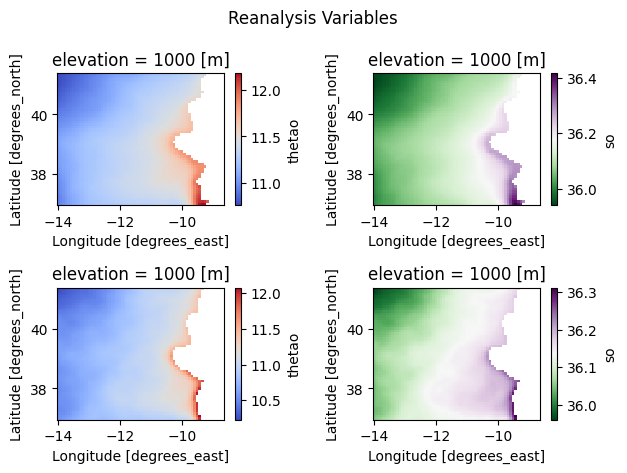

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.suptitle("Reanalysis Variables")

GLO_temp_rean_subset2.plot(ax=axes[0,0], cmap = 'coolwarm') #Temperature GLO
GLO_sal_rean_subset2.plot(ax=axes[0,1], cmap = 'PRGn_r') #Salinity GLO
IBI_temp_rean_subset2.plot(ax=axes[1,0], cmap = 'coolwarm') #Temperature IBI
IBI_sal_rean_subset2.plot(ax=axes[1,1], cmap = 'PRGn_r') #Salinity IBI

fig.tight_layout(pad=1.20)

plt.show()

Plot monthly mean time-series for temperature and salinity for each dataset. 

In [23]:
#Temp
GLO_temp_rean_subset1 = np.mean(GLO_temp_rean_subset, axis = (1,2))
IBI_temp_rean_subset1 = np.mean(IBI_temp_rean_subset, axis = (1,2))

GLO_temp_int_subset1 = np.mean(GLO_temp_int_subset, axis = (1,2))
IBI_temp_int_subset1 = np.mean(IBI_temp_int_subset, axis = (1,2))

#Sal
GLO_sal_rean_subset1 = np.mean(GLO_sal_rean_subset, axis = (1,2))
IBI_sal_rean_subset1 = np.mean(IBI_sal_rean_subset, axis = (1,2))

GLO_sal_int_subset1 = np.mean(GLO_sal_int_subset, axis = (1,2))
IBI_sal_int_subset1 = np.mean(IBI_sal_int_subset, axis = (1,2))


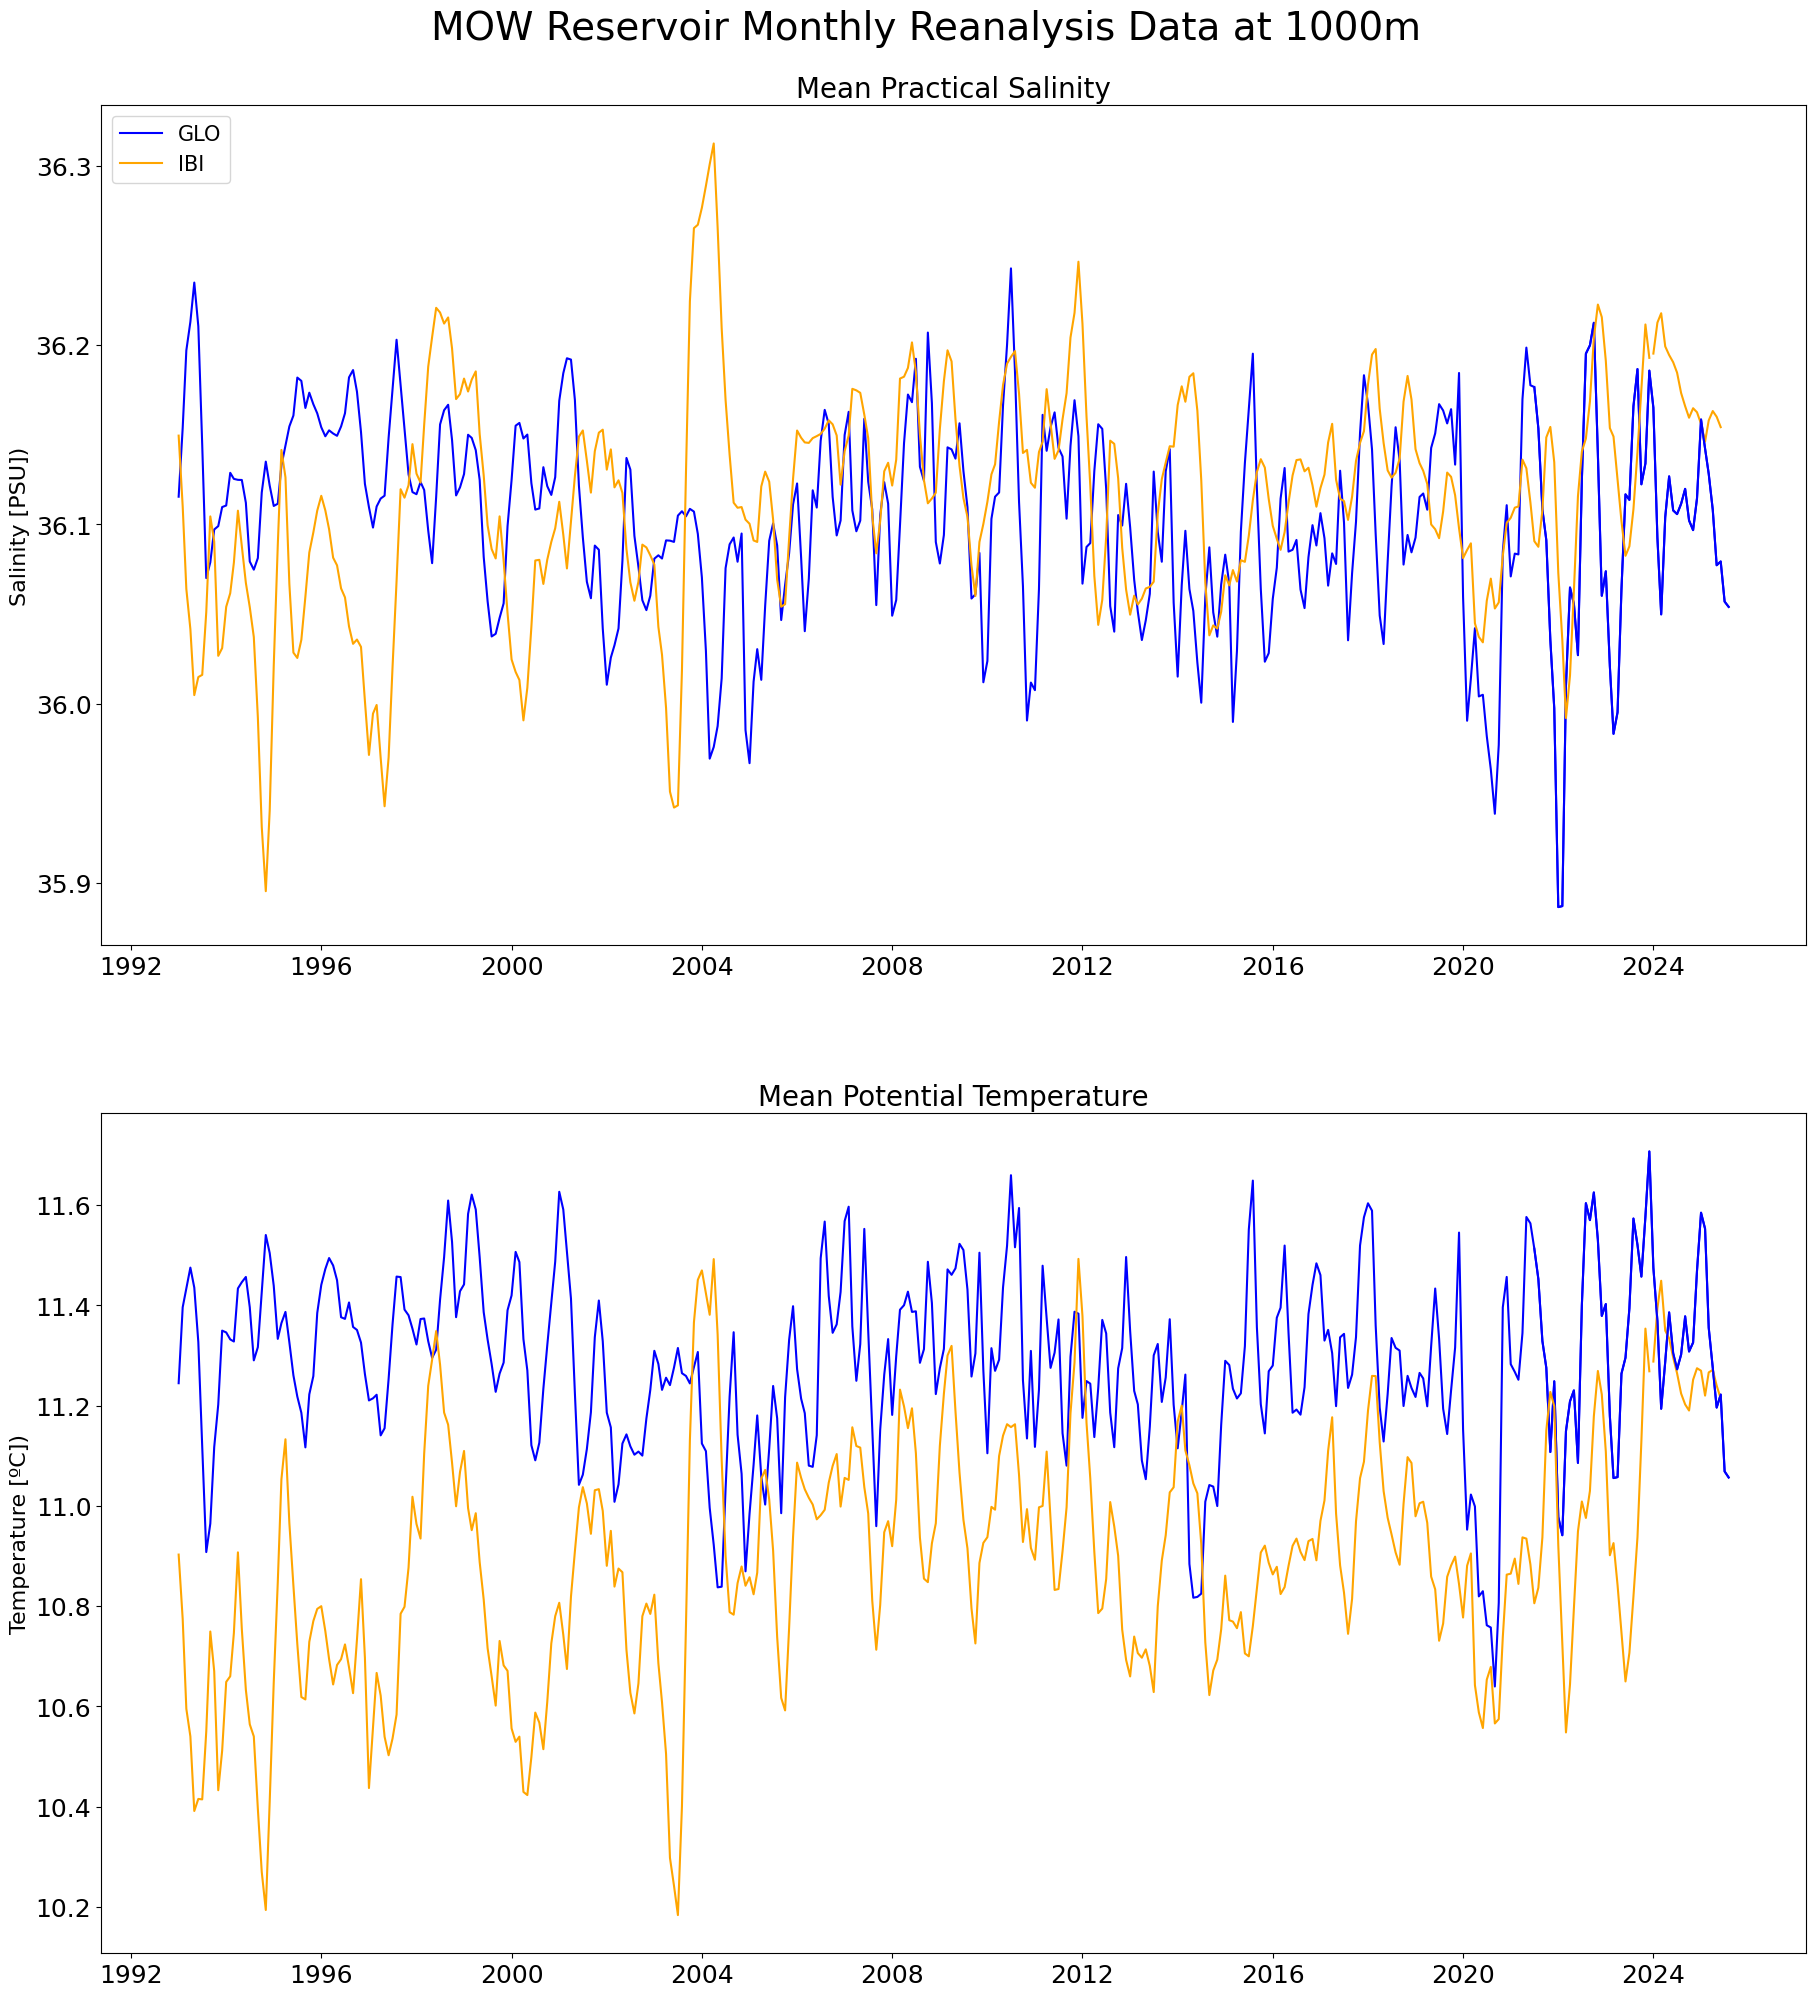

In [24]:
fig = plt.figure(figsize=[22,24])
fig.suptitle("MOW Reservoir Monthly Reanalysis Data at 1000m", fontsize = 28, y = 0.92)

ax1 = fig.add_subplot(2,1,1)
ax1.plot(GLO_int_ds['time'],GLO_sal_int_subset1, color = 'b', label = 'GLO')
ax1.plot(IBI_int_ds['time'],IBI_sal_int_subset1, color = 'orange', label = 'IBI')
ax1.plot(GLO_rean_ds['time'],GLO_sal_rean_subset1, color = 'b')
ax1.plot(IBI_rean_ds['time'],IBI_sal_rean_subset1, color = 'orange')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax1.set_title('Mean Practical Salinity', fontsize = 20)
ax1.set_ylabel("Salinity [PSU])", color= 'k', fontsize=16)
ax1.legend(loc=2, prop={'size': 15})

ax1 = fig.add_subplot(2,1,2)
ax1.plot(GLO_int_ds['time'],GLO_temp_int_subset1, color = 'b', label = 'GLO')
ax1.plot(IBI_int_ds['time'],IBI_temp_int_subset1, color = 'orange', label = 'IBI')
ax1.plot(GLO_rean_ds['time'],GLO_temp_rean_subset1, color = 'b')
ax1.plot(IBI_rean_ds['time'],IBI_temp_rean_subset1, color = 'orange')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax1.set_title('Mean Potential Temperature', fontsize = 20)
ax1.set_ylabel("Temperature [ºC])", color= 'k', fontsize=16)
#ax1.legend(loc=2, prop={'size': 15})

plt.show()